In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint # Differential equation solver
from lmfit import minimize, Parameters, Parameter, report_fit # Tool for fitting parameters

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# --- USER CONFIGURATION ---
# NOTE: SIR models work best on Total/Cumulative Infected (Confirmed) cases.
# We will use the full data available (100%) for the best fit.
targets = ['Confirmed'] 


try:
    df = pd.read_csv('../Practice_models/Linear_regression/covid_data_clean_with_new_cases.csv')
except FileNotFoundError:
    print("ERROR: File not found. Please check the path.")
    df = pd.DataFrame() 

# 1. Prepare Data
# Get the total number of days and the total population (N)
N = df['Confirmed'].max() * 10 # Estimate the population (10 times the max confirmed is a common starting heuristic)
t = df['Day'].values

# Initial conditions (S0, I0, R0)
I0 = df['Confirmed'].iloc[0] # Initial infected is the first confirmed case count
R0 = 0
S0 = N - I0 - R0 # Initial susceptible population

# The Observed Data (what we are fitting the model to)
data = df['Confirmed'].values

# --- SIR MODEL DEFINITION ---
def sir_model(y, t, N, beta, gamma):
    """
    The SIR model differential equations.
    y is the current state [S, I, R]
    beta (β): effective contact rate
    gamma (γ): recovery rate
    """
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt

def fit_sir(params, t, data, N, S0, I0, R0):
    """
    Function to minimize (minimize the difference between model output and real data).
    """
    # Get parameters from lmfit
    beta = params['beta'].value
    gamma = params['gamma'].value
    
    # Solve the differential equations
    ret = odeint(sir_model, [S0, I0, R0], t, args=(N, beta, gamma))
    S, I, R = ret.T
    
    # We want to minimize the difference between the model's Infected (I) + Recovered (R) 
    # and the actual Confirmed cases (I+R is what Confirmed represents over time)
    model_output = I + R
    
    # Return the residual (difference)
    return model_output - data

SIR Model Fitting Complete
Total Estimated Population (N): 320,365,110
Optimal Contact Rate (β): 0.6852
Optimal Recovery Rate (γ): 0.6516
Reproductive Number (R0_eff): 1.0515

NOTE: R0 > 1.0 indicates the disease is still spreading.


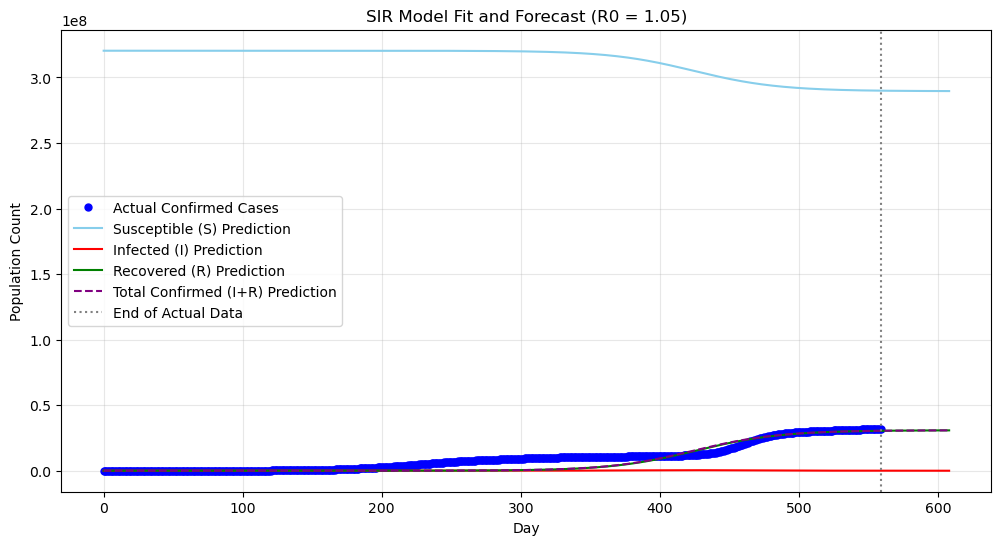

In [3]:
if not df.empty:
    # 1. Setup lmfit parameters
    params = Parameters()
    # beta (effective contact rate) - typically between 0.0 and 1.0
    params.add('beta', value=0.5, min=0.0, max=1.0) 
    # gamma (recovery rate) - typically between 0.0 and 1.0
    params.add('gamma', value=0.1, min=0.0, max=1.0)

    # 2. Run the optimization/fitting process
    result = minimize(fit_sir, params, args=(t, data, N, S0, I0, R0), method='leastsq')

    # 3. Get the best-fit parameters
    beta_fit = result.params['beta'].value
    gamma_fit = result.params['gamma'].value
    R0_effective = beta_fit / gamma_fit

    # 4. Use the best-fit parameters to run the final model prediction
    # Extend the timeline 50 days into the future for forecasting
    t_extended = np.arange(0, t[-1] + 50) 
    
    # Solve SIR model with optimized parameters
    fitted_sir_output = odeint(sir_model, [S0, I0, R0], t_extended, args=(N, beta_fit, gamma_fit))
    S_pred, I_pred, R_pred = fitted_sir_output.T
    
    # Model's total confirmed prediction is I + R
    Confirmed_pred = I_pred + R_pred
    
    # 5. Report and Print Key Epidemiological Metrics
    print("=" * 60)
    print("SIR Model Fitting Complete")
    print("=" * 60)
    print(f"Total Estimated Population (N): {N:,.0f}")
    print(f"Optimal Contact Rate (β): {beta_fit:.4f}")
    print(f"Optimal Recovery Rate (γ): {gamma_fit:.4f}")
    print(f"Reproductive Number (R0_eff): {R0_effective:.4f}")
    
    if R0_effective > 1:
        print("\nNOTE: R0 > 1.0 indicates the disease is still spreading.")
    else:
        print("\nNOTE: R0 < 1.0 indicates the disease is under control/declining.")
    
    # 6. Plotting 
    plt.figure(figsize=(12, 6))

    # Actual Data (Confirmed)
    plt.plot(t, data, 'o', color='blue', markersize=5, label='Actual Confirmed Cases')
    
    # Model Predictions
    plt.plot(t_extended, S_pred, color='skyblue', label='Susceptible (S) Prediction')
    plt.plot(t_extended, I_pred, color='red', label='Infected (I) Prediction')
    plt.plot(t_extended, R_pred, color='green', label='Recovered (R) Prediction')
    plt.plot(t_extended, Confirmed_pred, color='purple', linestyle='--', label='Total Confirmed (I+R) Prediction')

    plt.axvline(x=t[-1], color='gray', linestyle=':', label='End of Actual Data')

    plt.title(f'SIR Model Fit and Forecast (R0 = {R0_effective:.2f})')
    plt.xlabel('Day')
    plt.ylabel('Population Count')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()